## Data from Barkley Canyon (summer 1997)

Data collectd as part of the Canadian Global Ocean Ecosystems Dynamics Program (GLOBEC) and reported in Allen, Vinderinho, Thomson, et al. 2001.


CTD's at 16 stations (July 25-27, 1997), 5 moorings (April 19 to October 2, 1997)  

Data structure in the CTD files is:
 
 name 0 = scan: scan number
 
 name 1 = pr: pressure [db]
 
 name 2 = t090: temperature, pri, ITS-90 [deg C]
 
 name 3 = t190: temperature, sec, ITS-90 [deg C]
 
 name 4 = sal00: salinity, PSS-78 [PSU], T0, C0
 
 name 5 = sal11: salinity, PSS-78 [PSU], T1, C1
 
 name 6 = c0S/m: conductivity, primary [S/m]
 
 name 7 = c1S/m: conductivity, secondary [S/m]
 
 name 8 = xmiss: transmissometer
 
 name 9 = flag:  0.000e+00

In [167]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.io
import scipy.interpolate as interpolate
import seaborn as sns

In [158]:
def rd_station(filename):
    '''This function reads the data in the cnv file `filename` from the Barkley 1997 data set and
    gives back a data frame, df, with 10 columns: 
    scanNo 
    pressure : in dbar
    temp0 :  temperature, pri, ITS-90 [deg C]
    temp1: temperature, sec, ITS-90 [deg C]
    sal0:  salinity, PSS-78 [PSU], T0, C0
    sal1:  salinity, PSS-78 [PSU], T1, C1
    cond0: conductivity, primary [S/m]
    cond1: conductivity, secondary [S/m]
    transmissometer: transmissometer
    flag: 0.000e+00
    '''
    
    df = pd.read_csv(filename, delim_whitespace=True, skiprows=59, header = None,
                     names = ['scanNo', 'pressure', 'temp0', 'temp1', 'sal0', 'sal1',
                              'cond0', 'cond1', 'transmissometer', 'flag'])
    
    return(df)

def get_coords(filename):
    '''Get the cooridnates of the CTD cast station in the file `filename`. This function returns a tuple with decimal lon,
    lat where lon is W and lat is N '''
    
    with open(filename) as f:
        lines = f.readlines()
        lat = float((lines[8])[18:21]) + float((lines[8])[21:26])/60.
        lon = float((lines[9])[19:22]) + float((lines[9])[22:28])/60
        
    return -lon,lat

def get_depth(filename):
    '''Get the depth of the CTD cast station in the file `filename`. This function returns a float
    depth (positive number)'''
    
    with open(filename) as f:
        lines = f.readlines()
        depth = float((lines[14])[13:16])
    return depth

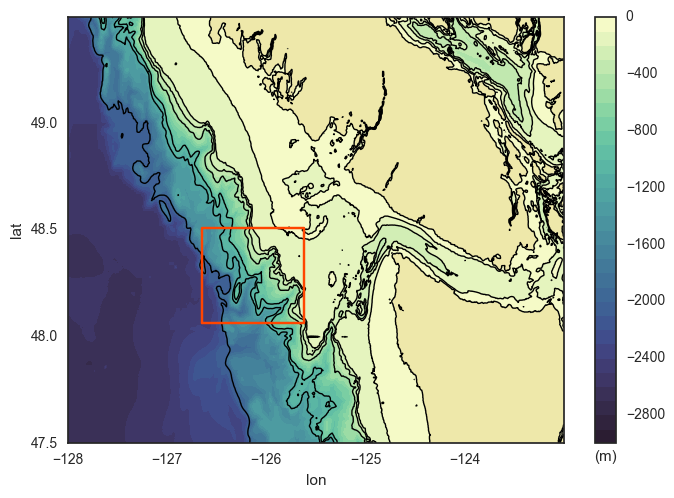

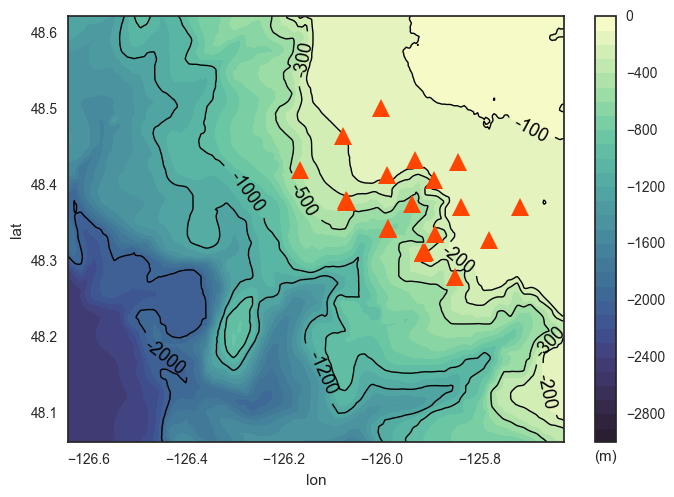

In [134]:
sns.set_style('white')

# plot stations
bathy = scipy.io.loadmat('/home/kramosmu/Research/Bathymetries/SouthVIgrid.mat')
dict.keys(bathy)

vigrid = bathy['SouthVIgrid']
lon = vigrid[0,0][0]
lon = np.squeeze(np.transpose(lon))
lat = vigrid[0,0][1]
lat = np.squeeze(np.transpose(lat))
dep = vigrid[0,0][2]

plt.rcParams['contour.negative_linestyle'] = 'solid'

# big map
fig, ax1 = plt.subplots(1,1)
ax1.set_axis_bgcolor('palegoldenrod')

CS2 = ax1.contourf(lon, lat, dep, np.linspace(-3000,0,31), cmap=cmo.cm.deep_r)
cb = plt.colorbar(CS2)
cb.ax.set_xlabel('(m)')
CS1 = ax1.contour(lon, lat, dep, (-3000,-2000,-1200,-1000,-500,-300,-200,-100,0),linewidths = 1, colors='k')
ax1.plot((lon[400],lon[700],lon[700],lon[400],lon[400]),(lat[250],lat[250],lat[450],lat[450],lat[250]), 
        '-',color='OrangeRed')
ax1.set_xlabel('lon')
ax1.set_ylabel('lat')

# zoomed in map
fig, ax2 = plt.subplots(1,1)
ax2.set_axis_bgcolor('palegoldenrod')

CS2 = ax2.contourf(lon[400:700], lat[250:500], dep[250:500,400:700], np.linspace(-3000,0,31), cmap=cmo.cm.deep_r)
cb = plt.colorbar(CS2)
cb.ax.set_xlabel('(m)')
CS1 = ax2.contour(lon[400:700], lat[250:500], dep[250:500,400:700], (-3000,-2000,-1200,-1000,-500,-300,-200,-100,0),linewidths = 1, colors='k')
plt.clabel(CS1, inline=1, fmt='%1.0f',fontsize=13)

ax2.set_xlabel('lon')
ax2.set_ylabel('lat')


# plot stations
for file in glob.glob(path_data + '*.cnv'):
    lon_st, lat_st = get_coords(file)
    ax2.plot(lon_st, lat_st, '^', color='OrangeRed',markersize = 13)


In [135]:
path_data = '/home/kramosmu/Research/Carine_data/'


st1 = rd_station(path_data + '97130201.cnv')

In [159]:
print(get_depth(path_data + '97130201.cnv'))

145.0


In [166]:
depth = get_depth(path_data + '97130201.cnv')

mean_bottom = (st1.loc[st1['pressure'] > depth-10.0]).mean(axis=0)
mean_bottom.temp1

interpolate.interp2d(lons, lats, salts, kind='spline')


6.9035435051546346

In [99]:
xnew = np.arange(-5.01, 5.01, 1e-2)
>>> ynew = np.arange(-5.01, 5.01, 1e-2)
>>> znew = f(xnew, ynew)
>>> plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
>>> plt.show()

In [160]:
st1.head(1)

,scanNo,pressure,temp0,temp1,sal0,sal1,cond0,cond1,transmissometer,flag
0,1,-0.104,14.3364,14.3391,30.7527,30.7563,3.763673,3.764304,49.72,0.0


* NMEA Latitude = 48 22.25 N

* NMEA Longitude = 125 43.04 W



ValueError: I/O operation on closed file.